In [446]:
import requests
url = 'https://apitempo.inmet.gov.br/estacao/2021-06-01/2022-05-23/A201'
resultado = requests.get(url)

In [447]:
import json
dados_org = resultado.json()
dados_str = json.dumps(dados_org)


In [448]:
import pandas as pd
import numpy as np

In [449]:
dados_tabla = pd.read_json(dados_str)
dados_tabla

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
0,BELÉM,1009.7,28.7,-1.411228,1009.7,PA,-0.6,22.3,26.5,-48.439512,...,0.4,21.9,26.8,13.1,3.5,29.0,26.5,78.0,A201,0
1,BELÉM,1010.1,28.6,-1.411228,1010.1,PA,-0.4,22.4,26.4,-48.439512,...,0.1,22.1,26.5,13.1,2.7,28.0,26.4,78.0,A201,100
2,BELÉM,1010.1,28.2,-1.411228,1010.2,PA,-1.1,22.5,25.8,-48.439512,...,0.5,22.1,26.4,13.0,2.6,28.0,25.8,82.0,A201,200
3,BELÉM,1010.1,28.8,-1.411228,1010.2,PA,-1.1,23.8,25.6,-48.439512,...,0.5,22.6,25.8,13.0,2.0,27.0,25.6,90.0,A201,300
4,BELÉM,1009.6,28.7,-1.411228,1010.1,PA,-0.7,24.2,25.3,-48.439512,...,0.3,23.9,25.6,13.0,2.5,27.0,25.3,93.0,A201,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,BELÉM,1010.2,27.4,-1.411228,1010.2,PA,139.7,23.7,24.3,-48.439512,...,1.0,23.1,28.5,13.3,7.4,30.0,24.4,96.0,A201,1900
8564,BELÉM,1011.7,22.3,-1.411228,1012.1,PA,184.8,21.5,21.8,-48.439512,...,2.5,21.3,24.9,13.1,14.9,27.0,22.0,97.0,A201,2000
8565,BELÉM,1011.5,24.7,-1.411228,1011.7,PA,10.5,21.5,21.8,-48.439512,...,0.4,21.4,22.1,13.0,8.6,25.0,21.9,98.0,A201,2100
8566,BELÉM,1012.1,25.1,-1.411228,1012.1,PA,1.4,21.9,21.9,-48.439512,...,0.0,21.5,22.2,13.0,2.5,24.0,22.2,98.0,A201,2200


In [450]:
dados = dados_tabla[['DT_MEDICAO', 'HR_MEDICAO', 'TEM_INS', 'UMD_INS', 'RAD_GLO']]
dados

,DT_MEDICAO,HR_MEDICAO,TEM_INS,UMD_INS,RAD_GLO
0,2021-06-01,0,26.5,78.0,-0.6
1,2021-06-01,100,26.4,78.0,-0.4
2,2021-06-01,200,25.8,82.0,-1.1
3,2021-06-01,300,25.6,90.0,-1.1
4,2021-06-01,400,25.3,93.0,-0.7
...,...,...,...,...,...
8563,2022-05-23,1900,24.4,96.0,139.7
8564,2022-05-23,2000,22.0,97.0,184.8
8565,2022-05-23,2100,21.9,98.0,10.5
8566,2022-05-23,2200,22.2,98.0,1.4


# Renomia o titulo do nosso dados

In [451]:
dados.columns = ['DATA','HORARIO', 'TEMPERATURA', 'UMIDADE', 'RADIACAO']

In [452]:
dados

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO
0,2021-06-01,0,26.5,78.0,-0.6
1,2021-06-01,100,26.4,78.0,-0.4
2,2021-06-01,200,25.8,82.0,-1.1
3,2021-06-01,300,25.6,90.0,-1.1
4,2021-06-01,400,25.3,93.0,-0.7
...,...,...,...,...,...
8563,2022-05-23,1900,24.4,96.0,139.7
8564,2022-05-23,2000,22.0,97.0,184.8
8565,2022-05-23,2100,21.9,98.0,10.5
8566,2022-05-23,2200,22.2,98.0,1.4


<AxesSubplot:title={'center':'TEMPERATURA'}, xlabel='HORARIO'>

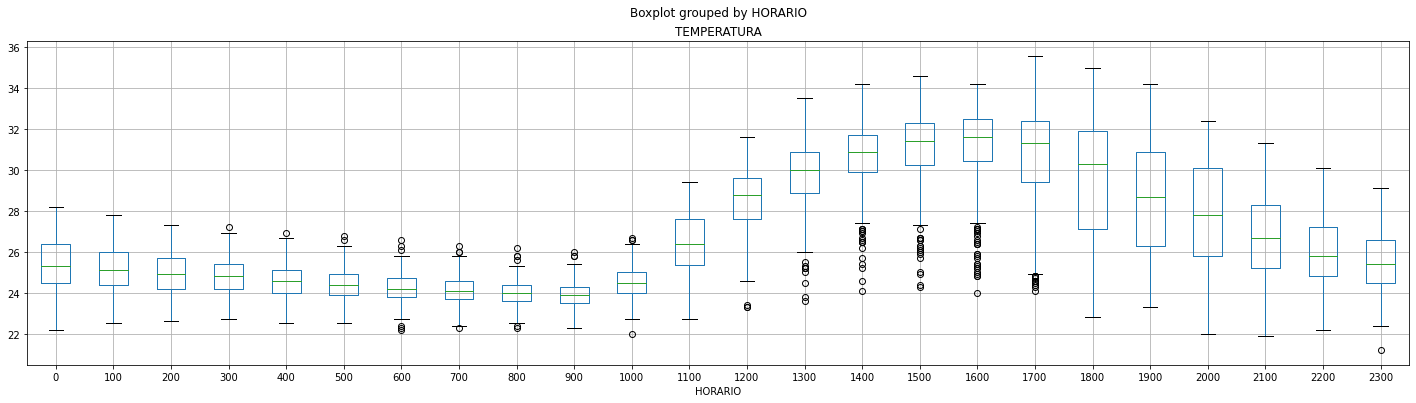

In [453]:
dados.boxplot("TEMPERATURA", by='HORARIO', figsize=(24,6))

<AxesSubplot:title={'center':'UMIDADE'}, xlabel='HORARIO'>

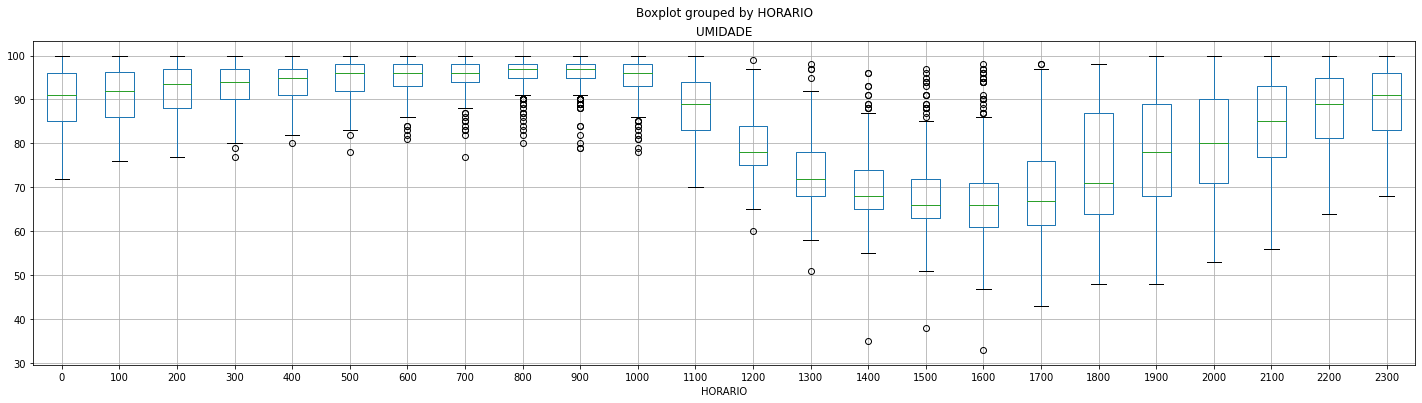

In [454]:
dados.boxplot("UMIDADE", by='HORARIO', figsize=(24,6))

<AxesSubplot:title={'center':'RADIACAO'}, xlabel='HORARIO'>

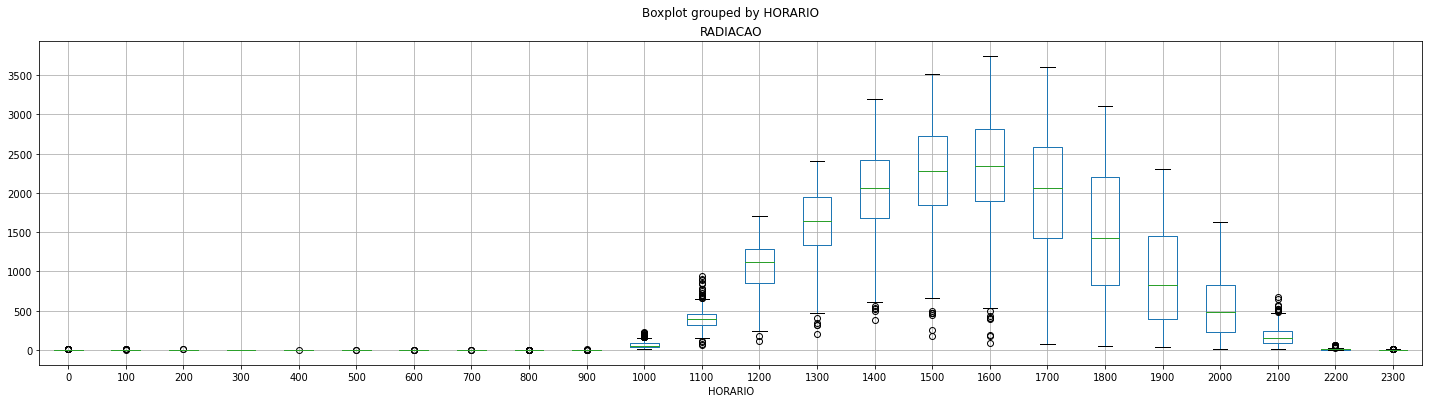

In [455]:
dados.boxplot("RADIACAO", by='HORARIO', figsize=(24,6))

# Verificando a suma de dados null 

In [456]:
dados.apply(pd.isnull).sum()/dados.shape[0]

DATA           0.000000
HORARIO        0.000000
TEMPERATURA    0.010621
UMIDADE        0.035247
RADIACAO       0.010621
dtype: float64

In [457]:
dados[pd.isnull(dados['TEMPERATURA'])]

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO
2864,2021-09-28,800,NaN,NaN,NaN
2865,2021-09-28,900,NaN,NaN,NaN
2866,2021-09-28,1000,NaN,NaN,NaN
2867,2021-09-28,1100,NaN,NaN,NaN
2868,2021-09-28,1200,NaN,NaN,NaN
...,...,...,...,...,...
6575,2022-03-01,2300,NaN,NaN,NaN
6625,2022-03-04,100,NaN,NaN,NaN
6722,2022-03-08,200,NaN,NaN,NaN
6817,2022-03-12,100,NaN,NaN,NaN


In [458]:
dados = dados.fillna(method='ffill')

In [459]:
dados.apply(pd.isnull).sum()/dados.shape[0]

DATA           0.0
HORARIO        0.0
TEMPERATURA    0.0
UMIDADE        0.0
RADIACAO       0.0
dtype: float64

# verificando se nosso dados são numéricos

In [460]:
dados.dtypes

DATA            object
HORARIO          int64
TEMPERATURA    float64
UMIDADE        float64
RADIACAO       float64
dtype: object

<AxesSubplot:>

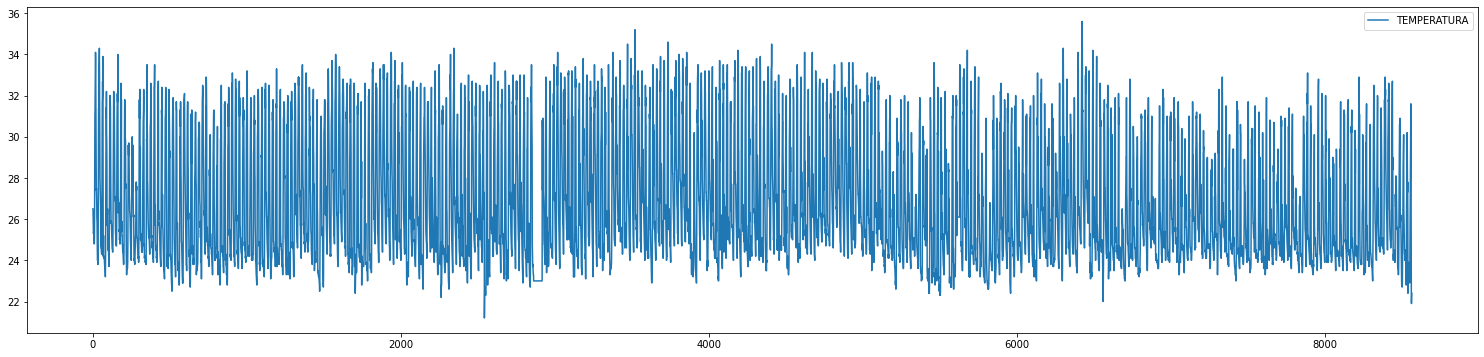

In [461]:
dados[['TEMPERATURA']].plot(figsize=(26,6))

# Agrupando os dados por horário

In [462]:
dados.groupby(dados.HORARIO).sum()

,TEMPERATURA,UMIDADE,RADIACAO
HORARIO,,,
0,9070.2,32102.0,-381.2
100,8998.8,32461.0,-485.2
200,8920.6,32862.0,-567.0
300,8847.1,33215.0,-649.0
400,8774.9,33507.0,-666.9
500,8709.6,33740.0,-692.6
600,8654.7,33942.0,-696.9
700,8605.5,34105.0,-694.8
800,8561.8,34215.0,-700.7


### Criando novos colunas para Temperatura da amahão, Umidade da amahão e Radiação da amahão na tabla  

In [463]:
dados

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO
0,2021-06-01,0,26.5,78.0,-0.6
1,2021-06-01,100,26.4,78.0,-0.4
2,2021-06-01,200,25.8,82.0,-1.1
3,2021-06-01,300,25.6,90.0,-1.1
4,2021-06-01,400,25.3,93.0,-0.7
...,...,...,...,...,...
8563,2022-05-23,1900,24.4,96.0,139.7
8564,2022-05-23,2000,22.0,97.0,184.8
8565,2022-05-23,2100,21.9,98.0,10.5
8566,2022-05-23,2200,22.2,98.0,1.4


### Criando novos colunas para Temperatura da amahão, Umidade da amahão e Radiação da amahão na tabla 

In [464]:
dados['TEMP_AMANHAO'] = dados.shift(-1)['TEMPERATURA']
dados['TEMP_MES_MIX'] = dados['TEMPERATURA'].rolling(30).mean()

In [465]:
dados['UMID_AMANHAO'] = dados.shift(-1)['UMIDADE']
dados['UMID_MES_MIX'] = dados['UMIDADE'].rolling(30).mean()

In [466]:
dados['RADI_AMANHAO'] = dados.shift(-1)['RADIACAO']
dados['RADI_MES_MIX'] = dados['RADIACAO'].rolling(30).mean()

In [467]:
dados

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO,TEMP_AMANHAO,TEMP_MES_MIX,UMID_AMANHAO,UMID_MES_MIX,RADI_AMANHAO,RADI_MES_MIX
0,2021-06-01,0,26.5,78.0,-0.6,26.4,NaN,78.0,NaN,-0.4,NaN
1,2021-06-01,100,26.4,78.0,-0.4,25.8,NaN,82.0,NaN,-1.1,NaN
2,2021-06-01,200,25.8,82.0,-1.1,25.6,NaN,90.0,NaN,-1.1,NaN
3,2021-06-01,300,25.6,90.0,-1.1,25.3,NaN,93.0,NaN,-0.7,NaN
4,2021-06-01,400,25.3,93.0,-0.7,25.4,NaN,91.0,NaN,-1.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8563,2022-05-23,1900,24.4,96.0,139.7,22.0,25.99,97.0,87.566667,184.8,718.700000
8564,2022-05-23,2000,22.0,97.0,184.8,21.9,25.82,98.0,88.100000,10.5,690.793333
8565,2022-05-23,2100,21.9,98.0,10.5,22.2,25.60,98.0,88.700000,1.4,648.806667
8566,2022-05-23,2200,22.2,98.0,1.4,22.4,25.34,98.0,89.400000,-0.1,582.016667


### Deletando NULL

In [468]:
dados = dados.iloc[30:,:].copy()
dados = dados.iloc[:-1, :].copy()

In [469]:
dados

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO,TEMP_AMANHAO,TEMP_MES_MIX,UMID_AMANHAO,UMID_MES_MIX,RADI_AMANHAO,RADI_MES_MIX
30,2021-06-02,600,24.0,97.0,-3.5,24.0,27.670000,97.0,78.700000,-2.4,628.220000
31,2021-06-02,700,24.0,97.0,-2.4,24.3,27.590000,96.0,79.333333,-2.3,628.153333
32,2021-06-02,800,24.3,96.0,-2.3,23.8,27.540000,99.0,79.800000,-2.8,628.113333
33,2021-06-02,900,23.8,99.0,-2.8,24.5,27.480000,99.0,80.100000,46.4,628.056667
34,2021-06-02,1000,24.5,99.0,46.4,26.7,27.453333,86.0,80.300000,459.6,629.626667
...,...,...,...,...,...,...,...,...,...,...,...
8562,2022-05-23,1800,28.5,79.0,1066.5,24.4,26.066667,96.0,87.133333,139.7,752.413333
8563,2022-05-23,1900,24.4,96.0,139.7,22.0,25.990000,97.0,87.566667,184.8,718.700000
8564,2022-05-23,2000,22.0,97.0,184.8,21.9,25.820000,98.0,88.100000,10.5,690.793333
8565,2022-05-23,2100,21.9,98.0,10.5,22.2,25.600000,98.0,88.700000,1.4,648.806667


In [470]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=0.1, solver='auto', fit_intercept=True, max_iter=None, tol=0.001, copy_X=True)

In [471]:
from sklearn.metrics import mean_absolute_percentage_error

In [491]:
numerio_de_dados = len(dados)-30

In [540]:
def criar_previsões_temp(preditores, dados, reg):
    numerio_de_dados = len(dados)-30
    trinar = dados.loc[:numerio_de_dados]
    teste = dados.loc[numerio_de_dados:]
    reg.fit(trinar[preditores], trinar["TEMP_AMANHAO"])
    preditores = reg.predict(teste[preditores])
    erro = mean_absolute_percentage_error(teste["TEMP_AMANHAO"],preditores)
    conjunto = pd.concat([test['TEMP_AMANHAO'], pd.Series(previsoes, index=test.index )], axis=1)
    conjunto.columns = ['ATUAL_TEMPERATURA', 'PREVISOES_TEMPERATURA']
    return erro, conjunto

In [502]:
def criar_previsões_umid(preditores, dados, reg):
    trinar = dados.loc[:numerio_de_dados]
    teste = dados.loc[numerio_de_dados:]
    reg.fit(trinar[preditores], trinar["UMID_AMANHAO"])
    preditores = reg.predict(teste[preditores])
    erro = mean_absolute_percentage_error(teste["UMID_AMANHAO"],preditores)
    conjunto = pd.concat([teste["UMID_AMANHAO"], pd.Series(preditores, index=teste.index)], axis=1)
    conjunto.columns = ["ATUAL_UMIDADE", "PREVISOES_UMIDADE"]
    return erro, conjunto

In [519]:
def criar_previsões_radi(preditores, dados, reg):
    trinar = dados.loc[:numerio_de_dados]
    teste = dados.loc[numerio_de_dados:]
    reg.fit(trinar[preditores], trinar["RADI_AMANHAO"])
    preditores = reg.predict(teste[preditores])
    erro = mean_absolute_percentage_error(teste["RADI_AMANHAO"],preditores)
    conjunto = pd.concat([teste["RADI_AMANHAO"], pd.Series(preditores, index=teste.index)], axis=1)
    conjunto.columns = ["ATUAL_RADIACAO", "PREVISOES_RADIACAO"]
    return erro, conjunto

In [475]:
preditores = ['HORARIO', 'TEMPERATURA','UMIDADE', 'RADIACAO','TEMP_MES_MIX', 'UMID_MES_MIX','RADI_MES_MIX']

In [541]:
temp_erro, temp_prevesao = criar_previsões_temp(preditores, dados, reg)

In [527]:
umid_erro, umid_prevesao = criar_previsões_umid(preditores, dados, reg)

In [495]:
radi_erro, radi_prevesao = criar_previsões_temp(preditores, dados, reg)

In [534]:
previsoes_dados = dados[["HORARIO"]]

In [548]:
previsoes_dados["ATUAL_TEMPERATURA", "PREVISOES_TEMPERATURA"] = temp_prevesao[["ATUAL_TEMPERATURA", "PREVISOES_TEMPERATURA"]]

ValueError: Expected a 1D array, got an array with shape (8537, 2)

In [538]:
previsoes_dados

,HORARIO
30,600
31,700
32,800
33,900
34,1000
...,...
8562,1800
8563,1900
8564,2000
8565,2100


In [528]:
umid_erro

0.03994633130439591

In [ ]:
umid_prevesao

In [524]:
temp_preditores

['HORARIO', 'TEMPERATURA']

In [ ]:
numerio_de_dados = len(dados)-30

In [ ]:
trinar = dados[:numerio_de_dados]

In [ ]:
test = dados[numerio_de_dados:]

In [ ]:
reg.fit(trinar[preditores], trinar['TEMP_AMANHAO'])

Ridge(alpha=0.1)

In [ ]:
previsoes = reg.predict(test[preditores])

In [ ]:
mean_absolute_percentage_error(test['TEMP_AMANHAO'], previsoes)

0.039567553828530624

In [ ]:
conjunto = pd.concat([test['TEMP_AMANHAO'], pd.Series(previsoes, index=test.index )], axis=1)
conjunto.columns = ['ATUAL_TEMPERATUA', 'PREVISOES_TEMPERATURA']

In [ ]:
conjunto["HORARIO"] = dados[["HORARIO"]]

In [ ]:
conjunto

,ATUAL_TEMPERATUA,PREVISOES_TEMPERATURA,HORARIO
8537,28.2,29.770805,1700
8538,27.3,28.115728,1800
8539,27.8,26.697294,1900
8540,26.3,27.294442,2000
8541,22.4,25.932707,2100
8542,23.1,22.778428,2200
8543,23.4,23.608518,2300
8544,23.9,23.776903,0
8545,23.8,24.268943,100
8546,23.8,24.205302,200


<AxesSubplot:title={'center':'PREVISOES_TEMPERATURA'}, xlabel='HORARIO'>

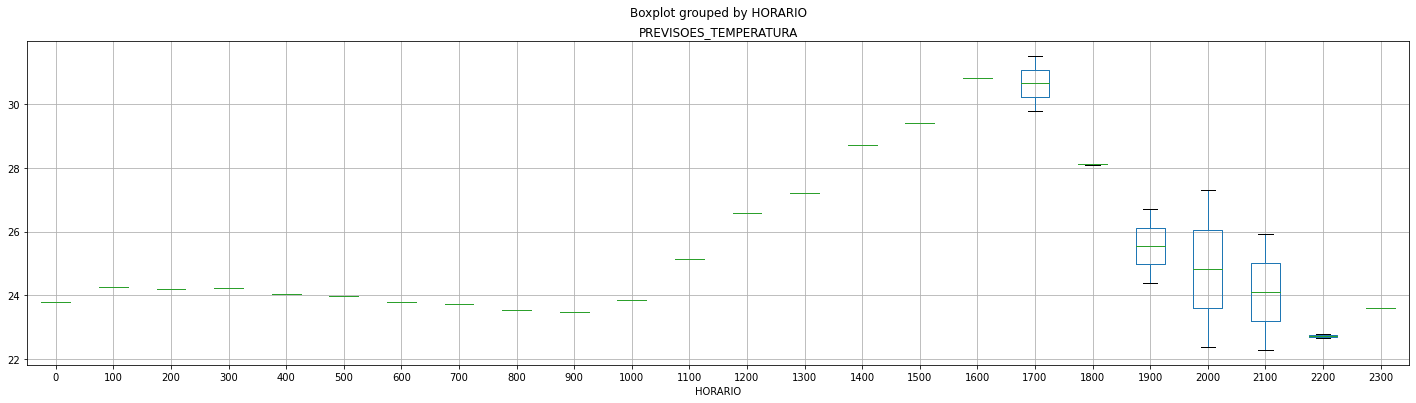

In [ ]:
conjunto.boxplot("PREVISOES_TEMPERATURA", by='HORARIO', figsize=(24,6))